## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
pip install odc-geo --quiet

In [204]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Load packages

In [206]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import GeoBox, Geometry
from odc.algo import mask_cleanup
import odc.geo.xr

from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import mostcommon_crs
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays
from dea_tools.coastal import tidal_tag
from coastlines.raster import model_tides

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42529 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41121 Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/42529/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


## Setup

In [3]:
dc = datacube.Datacube(app='Intertidal_elevation')

In [238]:
# aoi = 'Wollogorang'
# aoi = 'McCarthur River'
aoi = 'Greenbank'
# aoi = 'Seven Emu'

time_range = ('2017', '2021')
resolution = 10

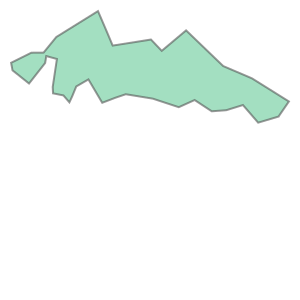

In [239]:
# Import regions of interest
aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

## Load data

In [240]:
# Create the 'query' dictionary object
query_params = {
    'geopolygon': geom,
    'time': time_range,
    'gqa_iterative_mean_xy': [0, 1]}
    
load_params = {
    'group_by': 'solar_day',
    'resampling': {'*': 'average', 'fmask': 'nearest'},
    'dask_chunks': {'time': 1, 'x': 2048, 'y': 2048}
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ga_s2am_ard_3', 
                            query=query_params)
output_crs

'epsg:32753'

In [261]:
# Load Sentinel-2 data
s2_ds = dc.load(product=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
                measurements=['nbart_green', 'nbart_nir_1', 's2cloudless_mask'],
                output_crs=output_crs,
                resolution=(-resolution, resolution),
                **query_params,
                **load_params).rename({'nbart_nir_1': 'nbart_nir'})

# Apply cloud masking
s2_ds = s2_ds.where(s2_ds.s2cloudless_mask == 1)

# Apply nodata masking
s2_ds = mask_invalid_data(s2_ds)
s2_ds

<xarray.Dataset>
Dimensions:           (time: 297, y: 3308, x: 8537)
Coordinates:
  * time              (time) datetime64[ns] 2017-01-26T01:07:20.460000 ... 20...
  * y                 (y) float64 8.254e+06 8.254e+06 ... 8.221e+06 8.221e+06
  * x                 (x) float64 6.581e+05 6.581e+05 ... 7.434e+05 7.435e+05
    spatial_ref       int32 32753
Data variables:
    nbart_green       (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nbart_nir         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    s2cloudless_mask  (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [262]:
# Load Landsat-8 data
ls_ds = dc.load(product=['ga_ls8c_ard_3'],
                measurements=['nbart_green', 'nbart_nir', 'fmask'],
                like=s2_ds.geobox,
                **{a:b for a, b in query_params.items() if a not in 'geopolygon'},
                **load_params)   

# Apply cloud masking
ls_ds = ls_ds.where(ls_ds.fmask.isin([1, 4, 5]))

# Apply nodata masking
ls_ds = mask_invalid_data(ls_ds)
ls_ds

<xarray.Dataset>
Dimensions:      (time: 212, y: 3308, x: 8537)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-12T00:59:26.866258 ... 2021-12...
  * y            (y) float64 8.254e+06 8.254e+06 ... 8.221e+06 8.221e+06
  * x            (x) float64 6.581e+05 6.581e+05 ... 7.434e+05 7.435e+05
    spatial_ref  int32 32753
Data variables:
    nbart_green  (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nbart_nir    (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    fmask        (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 53S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

In [263]:
# Combine into a single ds
ds = xr.concat([s2_ds.drop('s2cloudless_mask'), 
                ls_ds.drop('fmask')], dim='time').sortby('time')
ds

<xarray.Dataset>
Dimensions:      (time: 509, y: 3308, x: 8537)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-12T00:59:26.866258 ... 2021-12...
  * y            (y) float64 8.254e+06 8.254e+06 ... 8.221e+06 8.221e+06
  * x            (x) float64 6.581e+05 6.581e+05 ... 7.434e+05 7.435e+05
    spatial_ref  int32 32753
Data variables:
    nbart_green  (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nbart_nir    (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

## Intertidal elevation

In [264]:
# Calculate the water index
calculate_indices(ds,
                  index='NDWI',
                  collection='ga_ls_3', 
                  drop=True,
                  inplace=True)

Dropping bands ['nbart_green', 'nbart_nir']


<xarray.Dataset>
Dimensions:      (time: 509, y: 3308, x: 8537)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-12T00:59:26.866258 ... 2021-12...
  * y            (y) float64 8.254e+06 8.254e+06 ... 8.221e+06 8.221e+06
  * x            (x) float64 6.581e+05 6.581e+05 ... 7.434e+05 7.435e+05
    spatial_ref  int32 32753
Data variables:
    NDWI         (time, y, x) float64 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

Setting tide modelling location from dataset centroid: 136.88, -15.94


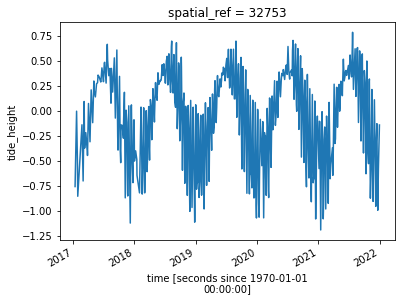

In [265]:
# Calculate tides for each timestep in the satellite dataset
tidal_tag(ds=ds, tidepost_lat=None, tidepost_lon=None)

# Plot the resulting tide heights for each Landsat image:
ds.tide_height.plot()

In [246]:
# lon, lat = ds.geobox.extent.to_crs('EPSG:4326').centroid.xy
# tides_out = model_tides(x=lon, y=lat, time=ds.time, directory='~/tide_models')
# ds['tide_height'] = tides_out.tide_m
# ds.tide_height.plot()

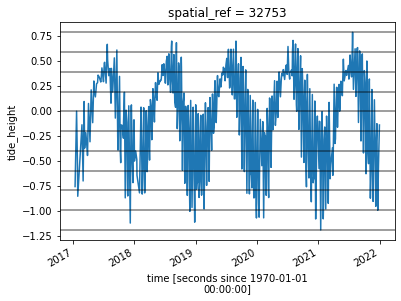

In [266]:
# classes
n = 10

# Sort every image by tide height
ds_clear = ds.sortby('tide_height')

# Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
binInterval = np.linspace(ds.tide_height.min(),
                          ds.tide_height.max(),
                          num=n+1)
tide_intervals = pd.cut(ds.tide_height,
                        bins=binInterval,
                        labels=range(1, n+1),
                        include_lowest=True)

# Add interval to dataset
ds['tide_interval'] = xr.DataArray(tide_intervals, coords=[ds.time])
ds.sortby('time').tide_height.plot()
for i in binInterval: plt.axhline(i, c='black', alpha=0.5)

In [267]:
# For each interval, compute the median water index and tide height value
landsat_intervals = (ds[['tide_interval', 'NDWI', 'tide_height']]
                     .groupby('tide_interval')
                     .median(dim='time')
                     .compute())

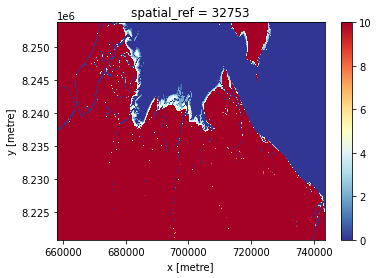

In [268]:
# Plot the resulting set of tidal intervals
item = ((landsat_intervals.NDWI < 0) * landsat_intervals.tide_interval).max(dim='tide_interval')
item.plot.imshow(cmap='RdYlBu_r')

In [269]:
# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_height.values})

# Extract waterlines
contours_gdf = subpixel_contours(da=item,
                                 z_values=[i - 0.5 for i in range(1, n + 1)],
                                 crs=ds.crs,
                                 affine=ds.geobox.transform,
                                 attribute_df=attribute_df,
                                 min_vertices=2,  #20,
                                 output_path='tide_intervals.geojson',
                                 dim='tide_interval')
# contours_gdf.explore(column='tide_m')

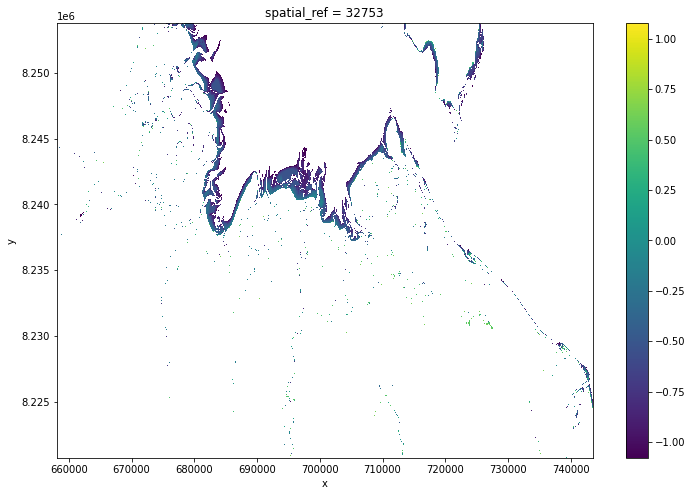

In [270]:
# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_m')

# Interpolate these XYZ points over the spatial extent of the Landsat dataset
intertidal_dem = interpolate_2d(ds=landsat_intervals,
                                x_coords=xyz_array[:, 0],
                                y_coords=xyz_array[:, 1],
                                z_coords=xyz_array[:, 2]).astype(np.float32)

# Identify areas that are always wet (e.g. below low tide), or always dry
# above_lowest = landsat_intervals.isel(tide_interval=0).NDWI < 0
# below_highest = landsat_intervals.isel(tide_interval=-1).NDWI > 0

# above_lowest = mask_cleanup(above_lowest, mask_filters=[('dilation', 1)])

above_lowest = item > item.min()
below_highest = item < item.max()

# Keep only pixels between high and low tide
intertidal_dem_clean = intertidal_dem.where(above_lowest & below_highest)

# Plot the cleaned dataset
intertidal_dem_clean.plot(cmap='viridis', size=8)
plt.show()

In [271]:
sensor = 's2ls'
# aoi = 'v1'
f'intertidal_dem_{sensor}_{aoi}.tif'

'intertidal_dem_s2ls_Greenbank.tif'

In [272]:
# Export as a GeoTIFF
write_cog(geo_im=intertidal_dem_clean, 
          fname=f'data/interim/intertidal_dem_{sensor}_{aoi}.tif', 
          overwrite=True)

PosixPath('data/interim/intertidal_dem_s2ls_Greenbank.tif')

In [260]:
import folium 

# Create folium Map
m = folium.Map()
intertidal_dem_clean.odc.reproject('epsg:3857', dst_nodata=np.nan).odc.add_to(m, opacity=1.0, vmin=-1.0, vmax=0.5) 
m.fit_bounds(intertidal_dem_clean.odc.map_bounds())
display(m)

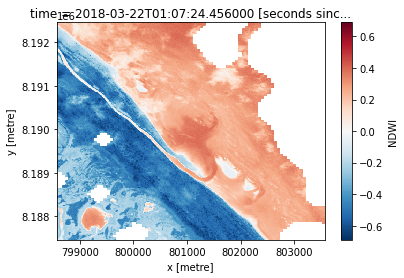

In [57]:
ds.isel(time=90).isel(x=slice(750, 1250), y=slice(700, 1200)).plot()

In [67]:
ds_small = ds[['NDWI', 'tide_height']].isel(x=slice(750, 1250), y=slice(700, 1200)).compute()

In [68]:
ds_small

<xarray.Dataset>
Dimensions:      (time: 509, y: 500, x: 500)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-14T00:47:04.662698 ... 2021-12...
  * y            (y) float64 8.192e+06 8.192e+06 ... 8.187e+06 8.187e+06
  * x            (x) float64 7.986e+05 7.986e+05 ... 8.036e+05 8.036e+05
    spatial_ref  int32 32753
Data variables:
    NDWI         (time, y, x) float64 nan nan nan nan ... 0.3215 0.3361 0.3636
    tide_height  (time) float64 -1.137 -0.143 -0.392 ... -0.465 -1.007 -0.092
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [70]:
from dea_tools.temporal import lag_linregress_3D

In [132]:
ds_small['NDWI_bool'] = (ds_small.NDWI > 0).where(~ds_small.NDWI.isnull())

In [189]:
out_ds = lag_linregress_3D(ds_small.NDWI_bool, ds_small.tide_height)

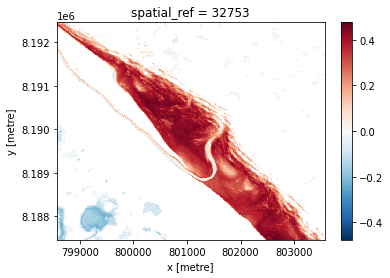

In [190]:
out_ds.cor.plot()

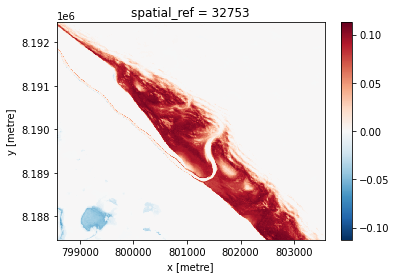

In [191]:
out_ds.cov.plot()

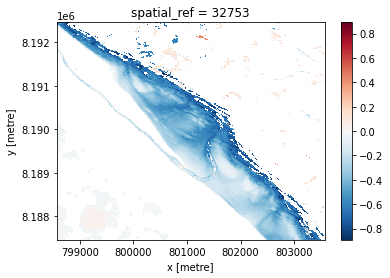

In [192]:
out_ds.intercept.plot()

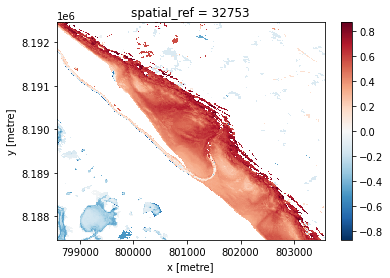

In [193]:
out_ds.slope.plot()

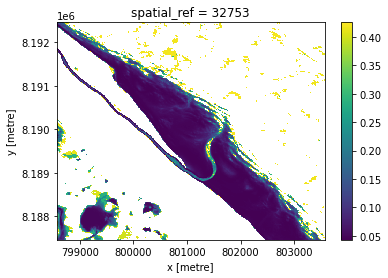

In [194]:
out_ds.stderr.plot()

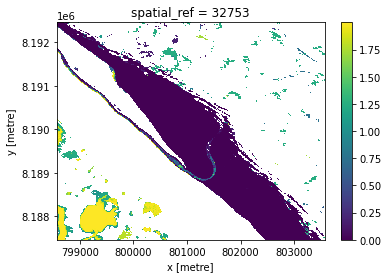

In [195]:
out_ds.pval.plot()

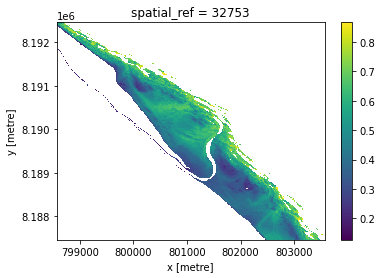

In [196]:
out_ds.slope.where(out_ds.pval < 0.01).plot()

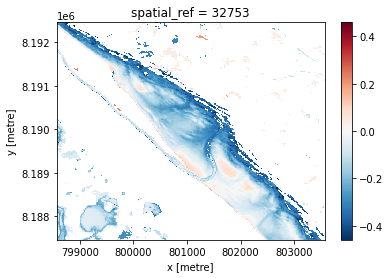

In [201]:
(out_ds.slope * 0.5 + out_ds.intercept).plot()

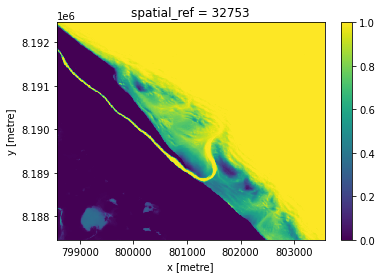

In [129]:

y - out_ds.intercept = out_ds.slope

In [ ]:
y = slope x + intercept

In [202]:
from datacube.utils.geometry import assign_crs
from datacube.utils.cog import write_cog
import numpy as np

# test_array = assign_crs(da_clean, yearly_ds.crs)
test_array = out_ds.intercept.where(out_ds.pval < 0.01)
test_array = (out_ds.slope * 0.5 + out_ds.intercept).where(out_ds.pval < 0.01)
write_cog(test_array.astype(float), 'test.tif', overwrite=True)


PosixPath('test.tif')

<AxesSubplot:xlabel='NDWI', ylabel='tide_height'>

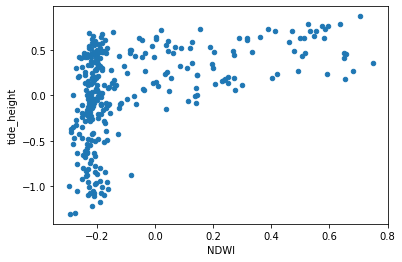

In [165]:
x=801076
y=8189187
ds_small.sel(x=x, y=y, method='nearest').to_dataframe().plot.scatter(x='NDWI', y='tide_height')

<AxesSubplot:xlabel='NDWI_bool', ylabel='tide_height'>

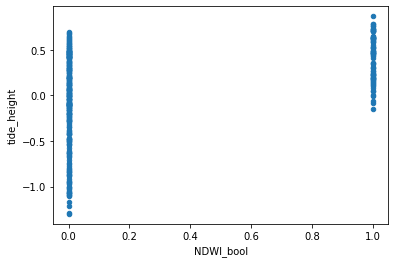

In [166]:
ds_small.sel(x=x, y=y, method='nearest').to_dataframe().plot.scatter(x='NDWI_bool', y='tide_height')

In [176]:
from scipy.stats import linregress

In [186]:
df = ds_small.sel(x=x, y=y, method='nearest').to_dataframe()[['NDWI_bool', 'tide_height']].dropna()

testing = linregress(x=df.NDWI_bool, y=df.tide_height)

In [188]:
(testing.slope * 0.5 + testing.intercept)

0.16570435039158846